## Simulating overdispersion using the `Spp` class

In the present notebook, which is based on ex07-Spp, we show how overdispersion can be simulated using the `pyross.stochastic.Spp` class. We consider the same SIR model as used in ex07-Spp, and compare several options for the overdispersion.

#### Overdispersion

Without overdispersion, during one infection event precisely one individual gets infected. With overdispersion, on average $\lambda $ individuals get infected. The value $\lambda $ is set via the parameter "overdispersion", as will be illustrated further below.

With overdispersion, the number $K$ of individuals that get infected in one infection event is a random variable. 
The overdispersion mode is set by the parameter "overdispersion_mode", and there are currently two distributions available in PyRoss:

##### 1. Poisson-distributed overdispersion (overdispersion_mode = 0, default)

Here, the number $K$ of newly infected individuals in one infection event is distributed according to a (shifted) Poisson distribution,
\begin{equation}
    K = X + 1,
\end{equation}
where $X$ is distributed according to 
\begin{equation}
P(X=n) = (\lambda-1)^{n} \frac{e^{-(\lambda-1)}}{n!}, \qquad n = \{0,1,2, ...\}.
\end{equation}
Note that $\langle K \rangle = \lambda$, and that $K \geq 1$, so that at least one person is infected in an infection event. By default, $\lambda = 1$, which corresponds to no overdispersion.

##### 2. Delta-peak overdispersion (overdispersion_mode = 1)

In this mode, the input $\lambda$ is rounded to next smallest integer, and $K$ is distributed according to a Kronecker delta,
\begin{equation}
P(K=k) = \delta_{k,\lambda},
\end{equation}
where $\lambda$ is understood to be an integer.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

### The SIR model

Below you will find the model-specification dictionary for the SIR model with some constant injection into the S class:

In [2]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "constant"  : [ ["k"] ], 
        "infection" : [ ["I", "-beta", "overdispersion"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta", "overdispersion"] ]
    }
}



## Example 1: Small population

We now consider an SIR model with a rather small population, and compare 

1. Gillespie simulations using Poisson-distributed overdispersion, with
2. Gillespie simulations using Delta-peak-distributed overdispersion.

In [3]:
overdispersion = 10

parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': overdispersion,
    'overdispersion_mode': 0, # Poisson distributed
}

We start by plotting a single example trajectory for Poisson-distributed overdispersion:

In [4]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    999, 1000, 1000, # S
    1,   0,    0,    # I
])

# Or initial conditions as a dictionary 
I0 = [20, 20, 20]
S0 = [n-20 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

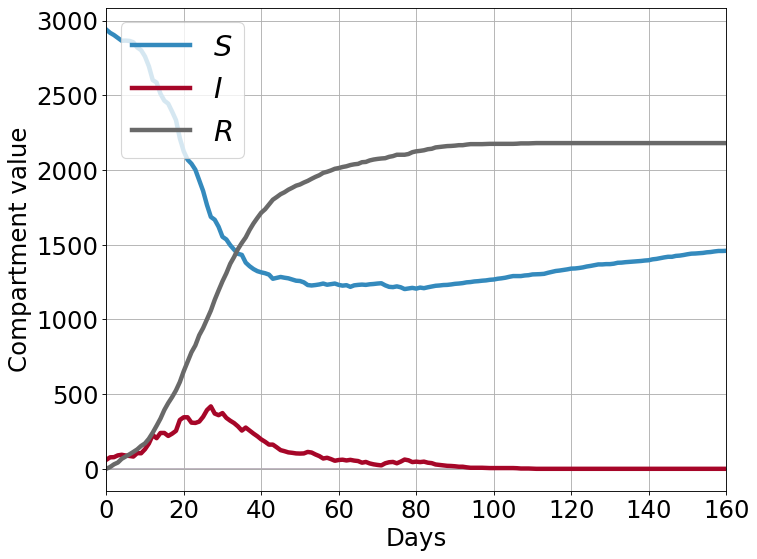

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

Now we run 100 simulations of both Poisson-distributed and Delta-peak-distributed overdispersion, and compare the resulting mean trajectory and corresponding standard deviation.

In [6]:
Ns = 100

trajectories = np.zeros( [Ns,3,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
    data = model.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model.model_class_data('S', data), axis=1)
    I = np.sum(model.model_class_data('I', data), axis=1)
    R = np.sum(model.model_class_data('R', data), axis=1)
    trajectories[i,0] = S.copy()
    trajectories[i,1] = I.copy()
    trajectories[i,2] = R.copy()
    #print(R)
    
mean_traj = np.mean(trajectories,axis=0)
std_traj = np.sqrt( np.var(trajectories,axis=0) )

In [7]:



parameters_2 = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion':overdispersion,
    'overdispersion_mode': 1, # Delta-peak 
}

trajectories_2 = np.zeros( [Ns,M,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model_2 = pyross.stochastic.Spp(model_spec, parameters_2, M, Ni)
    data = model_2.simulate(x0.copy(), contactMatrix, Tf, Nf,
                             method='tau-leaping',
                           nc=2*overdispersion,
                           epsilon = 0.03/overdispersion)
    S = np.sum(model_2.model_class_data('S', data), axis=1)
    I = np.sum(model_2.model_class_data('I', data), axis=1)
    R = np.sum(model_2.model_class_data('R', data), axis=1)
    trajectories_2[i,0] = S.copy()
    trajectories_2[i,1] = I.copy()
    trajectories_2[i,2] = R.copy() 

mean_traj_2 = np.mean(trajectories_2,axis=0)
std_traj_2 = np.sqrt( np.var(trajectories_2,axis=0) )

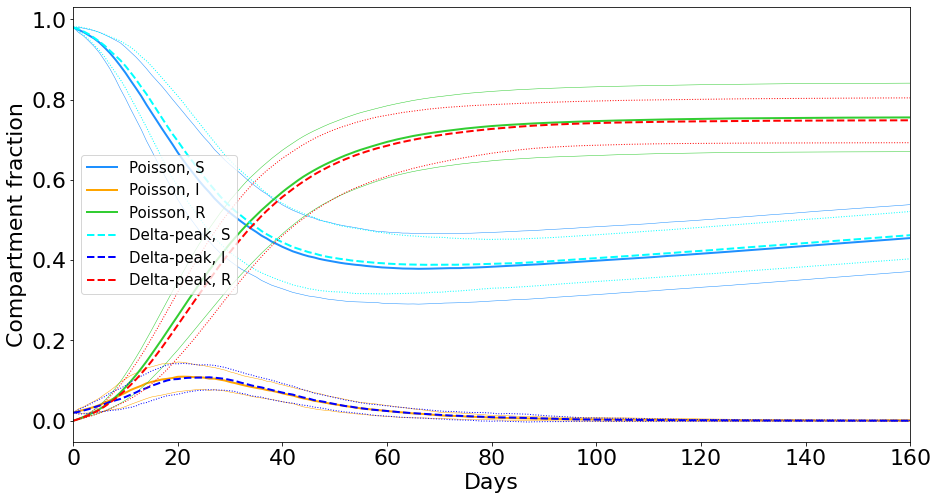

In [8]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

colors=['dodgerblue','orange','limegreen']
colors_2=['cyan','blue','red']
labels=['S','I','R']

plot_var = True

for i,e in enumerate(mean_traj):
    if plot_var:
        ax.plot(t,(e - std_traj[i])/N,
                lw=0.5,
                color=colors[i])
        ax.plot(t,(e + std_traj[i])/N,
                lw=0.5,
                color=colors[i])
    ax.plot(t,e/N,
            lw=2,
            color=colors[i],
           label='Poisson, ' + str(labels[i]))
    
for i,e in enumerate(mean_traj_2):
    if plot_var:
        ax.plot(t,(e - std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
        ax.plot(t,(e + std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
    ax.plot(t,e/N,ls='--',
            lw=2,
            color=colors_2[i],
            label='Delta-peak, ' + str(labels[i]))
    
ax.set_xlim(np.min(t),np.max(t))
ax.set_xlabel(r'Days')
ax.set_ylabel(r'Compartment fraction')
ax.legend(fontsize=15)
plt.show()
plt.close(fig)

## Example 2: Large population and large overdispersion

We now consider an SIR model with a larger population, and compare 

1. Gillespie simulations using Delta-peak-distributed overdispersion, with
2. Tau-leaping simulations using Poisson-distributed overdispersion.

Note that for tau-leaping, both the parameters "nc" and "epsilon" need to be adapted, to account for the fact that overdispersion can lead to faster variation of populations.

We start with an example trajectory from a Gillespie simulation using Delta-peak-distributed overdispersion:

In [9]:
M = 3                
Ni = 100000*np.ones(M)
N = np.sum(Ni) 


# Or initial conditions as a dictionary 
I0 = [2000, 2000, 2000]
S0 = [n-2000 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)


overdispersion = 300

parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': overdispersion,
    'overdispersion_mode': 1,
}

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 50;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

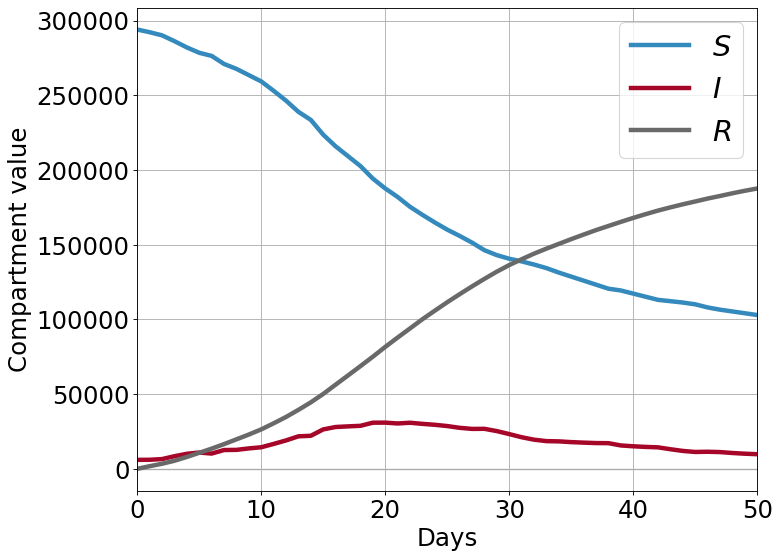

In [10]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [11]:
Ns = 100

trajectories = np.zeros( [Ns,3,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
    data = model.simulate(x0.copy(), contactMatrix, Tf, Nf)
    S = np.sum(model.model_class_data('S', data), axis=1)
    I = np.sum(model.model_class_data('I', data), axis=1)
    R = np.sum(model.model_class_data('R', data), axis=1)
    trajectories[i,0] = S.copy()
    trajectories[i,1] = I.copy()
    trajectories[i,2] = R.copy()
    
mean_traj = np.mean(trajectories,axis=0)
std_traj = np.sqrt( np.var(trajectories,axis=0) )

In [12]:
parameters_2 = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 1, 
    'overdispersion': overdispersion,
    'overdispersion_mode': 0,
}



trajectories_2 = np.zeros( [Ns,M,Nf] , 
                        dtype=float)

for i in range(Ns):
    print(i,end='\r')
    model_2 = pyross.stochastic.Spp(model_spec, parameters_2, M, Ni,
                                   )
    data = model_2.simulate(x0.copy(), contactMatrix, Tf, Nf,
                            method='tau-leaping',
                           nc=min( 3*overdispersion, 30 ), # definitely switch to gillespie when a
                                                        # population is comparable to the overdispersion
                           epsilon = 0.03/overdispersion)  # decrease the timestep by the overdispersion
    S = np.sum(model_2.model_class_data('S', data), axis=1)
    I = np.sum(model_2.model_class_data('I', data), axis=1)
    R = np.sum(model_2.model_class_data('R', data), axis=1)
    trajectories_2[i,0] = S.copy()
    trajectories_2[i,1] = I.copy()
    trajectories_2[i,2] = R.copy() 

mean_traj_2 = np.mean(trajectories_2,axis=0)
std_traj_2 = np.sqrt( np.var(trajectories_2,axis=0) )

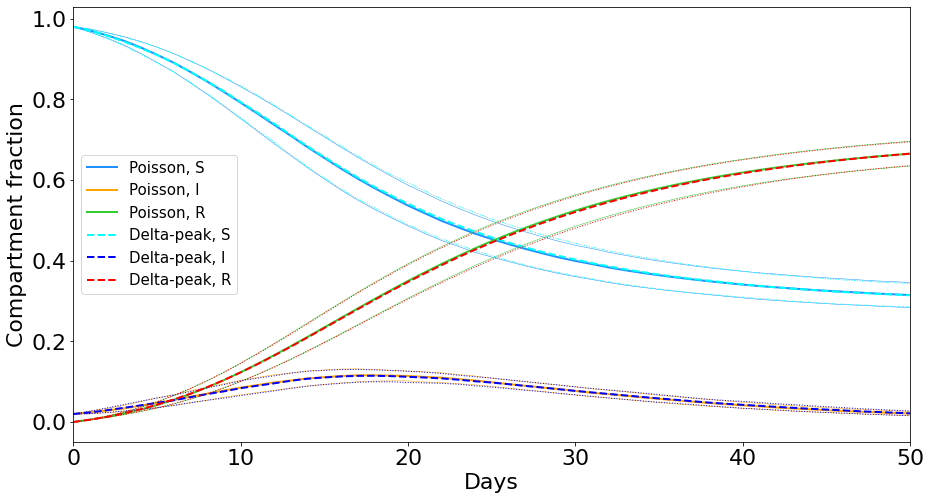

In [13]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

colors=['dodgerblue','orange','limegreen']
colors_2=['cyan','blue','red']
labels=['S','I','R']

plot_var = True

for i,e in enumerate(mean_traj):
    if plot_var:
        ax.plot(t,(e - std_traj[i])/N,
                lw=0.5,
                color=colors[i])
        ax.plot(t,(e + std_traj[i])/N,
                lw=0.5,
                color=colors[i])
    ax.plot(t,e/N,
            lw=2,
            color=colors[i],
           label='Poisson, ' + str(labels[i]))
    
for i,e in enumerate(mean_traj_2):
    if plot_var:
        ax.plot(t,(e - std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
        ax.plot(t,(e + std_traj_2[i])/N,
                lw=1,
                ls='dotted',
                color=colors_2[i])
    ax.plot(t,e/N,ls='--',
            lw=2,
            color=colors_2[i],
            label='Delta-peak, ' + str(labels[i]))
    
ax.set_xlim(np.min(t),np.max(t))
ax.set_xlabel(r'Days')
ax.set_ylabel(r'Compartment fraction')
ax.legend(fontsize=15)
plt.show()
plt.close(fig)